In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] = "/home/pleon/mylammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.slab import initialize_slab
from mcmc.system import SurfaceSystem
from mcmc.calculators import LAMMPSRunSurfCalc

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
element = "Cu"
alat = 3.6147
slab = initialize_slab(alat, elem=element, size=(2, 2, 2), miller=(1, 0, 0))

system_settings = {
    "surface_name": "Cu(100)",
    "cutoff": 5.0,
    "lattice_param": {"Cu": alat},
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 0.99,  # slowly anneal
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 20,
    "sweep_size": 2,
}

calc_settings = {
    "calc_name": "eam",
    "optimizer": "FIRE",
    "chem_pots": {"Cu": 0.0},
    "relax_atoms": False,
    "relax_steps": 100,
    "run_dir": "Cu(100)",
}

Get adsorption coordinates (there are only 8 in the new code compared with 16 in the old code)

In [4]:
pristine_slab = slab.copy()

from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=True,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 0.   ,  5.112, 18.307]), array([ 2.556,  3.834, 18.307])]...


In [5]:
pristine_slab.get_tags()

array([2, 2, 2, 2, 1, 1, 1, 1])

Set up LAMMPS (calculator)

In [6]:
# use LAMMPS
parameters = {"pair_style": "eam", "pair_coeff": ["* * Cu_u3.eam"]}

# set up the LAMMPS calculator
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], "Cu_u3.eam")
lammps_surf_calc = LAMMPSRunSurfCalc(
    files=[potential_file],
    keep_tmp_files=False,
    keep_alive=False,
    tmp_dir=os.path.join(os.path.expanduser("~"), "tmp_files"),
)
lammps_surf_calc.set(**parameters)

Initialize surface system

In [7]:
surface = SurfaceSystem(
    pristine_slab,
    ads_coords=ads_positions,
    calc=lammps_surf_calc,
    system_settings=system_settings,
)
surface.all_atoms.write("Cu_100_2x2x2_all_virtual_ads.cif")

2024-06-20 11:46:45,999|INFO|initializing 2 virtual atoms
2024-06-20 11:46:46,001|INFO|initial state is [0 0]
2024-06-20 11:46:46,003|INFO|number of pristine atoms is 8
2024-06-20 11:46:46,003|INFO|bulk indices are []
2024-06-20 11:46:46,004|INFO|surface indices are [4 5 6 7]
2024-06-20 11:46:46,004|INFO|Real atoms have constraints [FixAtoms(indices=[])]


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `Cu(100)/` folder.

2024-06-20 11:46:46,048|INFO|there are 8 atoms in pristine slab
2024-06-20 11:46:46,049|INFO|Running with num_sweeps = 20, temp = 1.0, pot = [0.0], alpha = 0.99
2024-06-20 11:46:46,050|INFO|In pristine slab, there are a total of 2 sites


2024-06-20 11:46:46,071|INFO|running for 2 iterations per run over a total of 20 runs
2024-06-20 11:46:46,072|INFO|starting with iteration 0
2024-06-20 11:46:46,073|INFO|In sweep 1 out of 20
2024-06-20 11:46:46,121|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,124|INFO|In sweep 2 out of 20
2024-06-20 11:46:46,192|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,196|INFO|In sweep 3 out of 20
2024-06-20 11:46:46,246|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,251|INFO|In sweep 4 out of 20


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


2024-06-20 11:46:46,322|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,327|INFO|In sweep 5 out of 20
2024-06-20 11:46:46,386|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,390|INFO|In sweep 6 out of 20
2024-06-20 11:46:46,448|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,453|INFO|In sweep 7 out of 20
2024-06-20 11:46:46,527|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,531|INFO|In sweep 8 out of 20
2024-06-20 11:46:46,582|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,586|INFO|In sweep 9 out of 20
2024-06-20 11:46:46,632|INFO|optim structure has Energy = -24.05847629446562
2024-06-20 11:46:46,636|INFO|In sweep 10 out of 20
2024-06-20 11:46:46,703|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,707|INFO|In sweep 11 out of 20
2024-06-20 11:46:46,756|INFO|optim structure has Energy = -25.28930651224759
2024-06-20 11:46:46,760|INFO|In 

Time taken = 1.5310929659754038 seconds


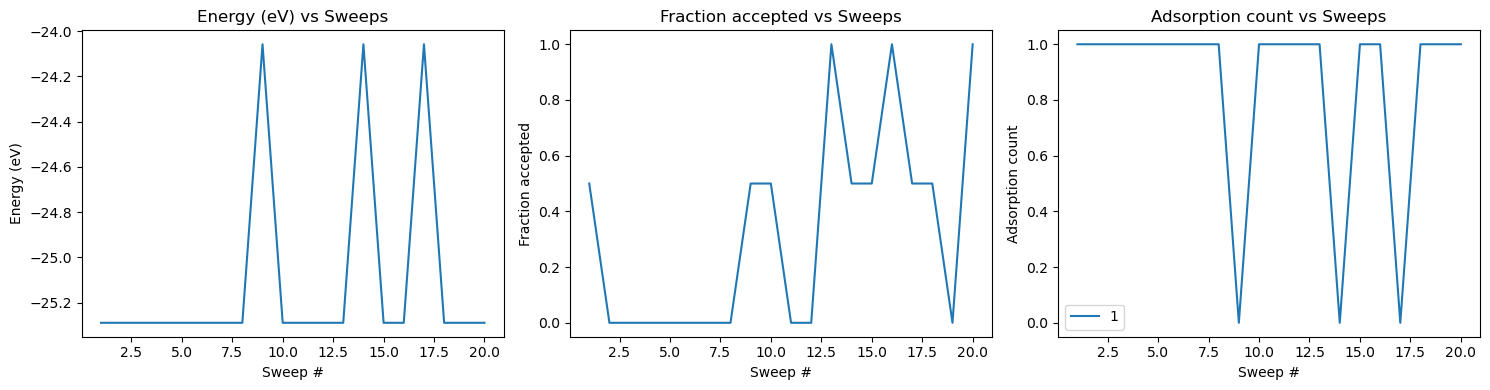

In [8]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=lammps_surf_calc,
    canonical=False,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    optimizer=calc_settings["optimizer"],
)  # no relaxation

start = perf_counter()
# call the main function
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)

stop = perf_counter()
print(f"Time taken = {stop - start} seconds")